<a href="https://colab.research.google.com/github/mark47B/MIP-project/blob/main/Interpolation_MIP_HOROSHO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание
Реализовать интерполяцию траектории с несколькими точками (параграф 9.3)

Необходимо, чтобы шарниры робота проходили через ряд точек перехода в определенное время без строгой спецификации формы пути между последовательными точками.

В случае интерполирования полиномом 3го порядка, нам достаточно знать координату и скорость.

В случае полинома 5го порядка понадобится ускорение.

Пусть траектория задана через k точек, с начальной точкой в $T_1 = 0$ и конечной точкой в $T_k = T$.



*   В каждой промежуточной точке $i ∈ {1, . . . , k}$, указывается желаемое положение $β(T_i) = β_i$ и скорость $β̇(T_i) = β̇_i$.
*   Траектория состоит из $k − 1$ отрезков, а длительность отрезка $j ∈ {1, . . . , k − 1}$ есть $∆T_j = T_{j+1} − T_j$ .






# Интерполяция полиномом 3го порядка
Пример взят из книги "MODERN ROBOTICS MECHANICS, PLANNING, AND CONTROL" Kevin M. Lynch and Frank C. Park, параграф 9.3 "Polynomial Via Point Trajectories"


В примере  траектория на участке $j$ выражается полиномом третьего порядка.

$\beta(T_j + \Delta t) = a_{j0} + a_{j1} \Delta t + a_{j2} \Delta t^2 + a_{j3} \Delta t^3 $


In [197]:
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce

In [198]:
def get_interpolation_cof(T, b, db):
  '''
  Генерирует коэффициенты для полинома 3го порядка
  T: Время
  b: Координаты
  db: Скорости
  -------
  return : dict:= Время: [список коэффициентов]
  '''
  return {T[j]: [b[j],
                 db[j],
                 (3*b[j+1] - 3*b[j] - 2*db[j]* (T[j+1] - T[j]) - db[j+1] * (T[j+1] - T[j]))/((T[j+1] - T[j]) ** 2),
                 (2*b[j] + (db[j] + db[j+1])*(T[j+1] - T[j]) - 2*b[j+1])/((T[j+1] - T[j]) ** 3)
                 ] for j in range(len(T) - 1)}


In [199]:
def poly(coefs: list, delta_time: float) -> float:
  '''
  Вычисляет значение полинома с коэффициентами
  '''
  P = [ cof * delta_time**deg for deg, cof in enumerate(coefs)]
  return reduce(lambda a, b: a + b, P)


In [200]:
def get_dpoly(coefs: list, delta_time: float) -> float:
  '''
  Вычисляет значение производной полинома c коэффициентами
  '''
  dP = [ cof * (deg+1) * delta_time**(deg) for deg, cof in enumerate(coefs[1:])]
  return reduce(lambda a, b: a + b, dP)

In [201]:
from collections.abc import Callable

class InterLine:
  '''
  Класс для хранения интерполированных кривых
  '''

  def __init__(self, color: str, name: str, time_cofs: dict, linestyle: str ='solid'):
      self.color = color
      self.linestyle = linestyle
      self.name = name
      self.time_cofs = time_cofs

  def fnc_value(self, fnc: Callable, time, index, time_range):
    return [fnc(self.time_cofs[time[index]], dot_time-time[index]) for dot_time in time_range]

  def plot(self, ax, times, fnc):
    dot_x = []
    dot_y = []
    diff_list = np.diff(times)
    min_diff = np.min(diff_list)

    for index,time in enumerate(times[1:]):
      delta_time = time - times[index]

      n_dots = round(delta_time/min_diff)*100

      time_range = np.linspace(times[index], time, n_dots)
      dot_values = self.fnc_value(fnc, times,index,time_range)
      dot_x += list(time_range)
      dot_y += dot_values
    ax.plot(dot_x, dot_y, label=self.name, linestyle=self.linestyle, color =self.color)

## Проверка на примере из учебника
Должно быть так

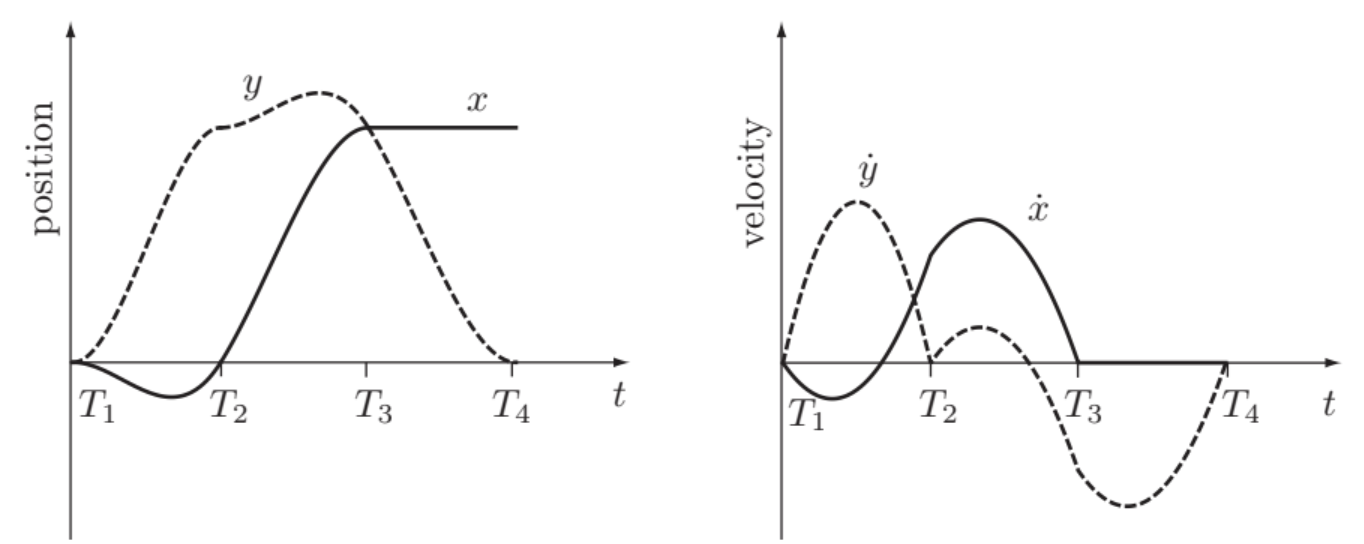

Получаем

In [202]:
x = [0, 0, 1, 1]
y = [0, 1, 1, 0]
v_x = [0, 1, 0, 0]
v_y = [0, 0, -1, 0]
t = [0, 1, 2, 3]

In [203]:
a_x = get_interpolation_cof(t, x, v_x)
a_y = get_interpolation_cof(t, y, v_y)

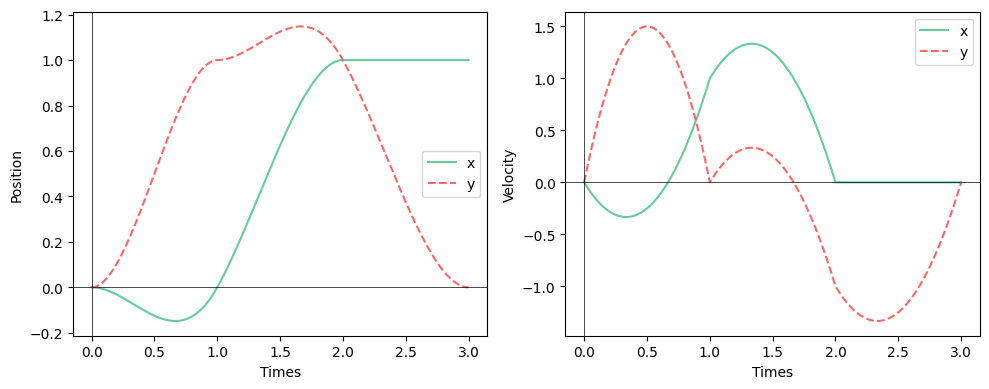

In [204]:
fig, axis = plt.subplots(1, 2, figsize=(10, 4))

y_labels = ('Position','Velocity')

x = InterLine(color='#6c9',linestyle='solid',name='x', time_cofs=a_x)
y = InterLine(color='#f66',linestyle='dashed',name='y', time_cofs=a_y)
lines = (x,y)

fnc_list = (poly, get_dpoly)

for fnc, ax, y_label in zip(fnc_list, axis, y_labels):
  for line in lines:
    line.plot(ax, t, fnc)

  ax.axhline(0, color='black', linewidth=0.5)
  ax.axvline(0, color='black', linewidth=0.5)
  ax.set_xlabel('Times')
  ax.set_ylabel(y_label)
  ax.legend()


plt.tight_layout()
plt.show()

# Интерполяция полиномом 5й степени

## Постановка задачи


Учитывая, что мы знаем координату, скорость и ускроение, то получим следующие полиномы.


$\beta(T_j + \Delta t) = a_{j0} + a_{j1} \Delta t + a_{j2} \Delta t^2 + a_{j3} \Delta t^3 + a_{j4} \Delta t^4 + a_{j5} \Delta t^5 $


$\dot{\beta}(T_j + \Delta t) = a_{j1} + 2 a_{j2} \Delta t + 3 a_{j3} \Delta t^2 + 4 a_{j4} \Delta t^3 + 5 a_{j5} \Delta t^4 $

$\ddot{\beta}(T_j + \Delta t) = 2 a_{j2} + 6 a_{j3} \Delta t + 12 a_{j4} \Delta t^2 + 20 a_{j5} \Delta t^3 $

Где $\Delta t = T_{j+1} - T_{j}$

Раннее определили функции get_poly, get_dpoly, которые соответствуют первым двум функциям. Сейчас доопределим get_ddpoly, которая будет отвечать за вторую прозиводную $-$ ускорение.



In [205]:
def get_ddpoly(coefs: list, delta_time: float) -> float:
  '''
  Вычисляет значение второй производной полинома c коэффициентами
  '''
  dP = [(deg+1)*(deg+2) * cof * delta_time**(deg) for deg, cof in enumerate(coefs[2:])]
  return reduce(lambda a, b: a + b, dP)

Очевидно, что будут следующие ограничения.

$\beta(T_j) = a_{j0}  = \beta_j\\
\dot{\beta}(T_j) = a_{j1} = \dot{\beta}_j\\
\ddot{\beta}(T_j) = 2 a_{j2} =\ddot{\beta}_j \\
\beta(T_j+\Delta T_j)=\beta_{j+1} \\
\dot{\beta}(T_j+\Delta T_j) = \dot{\beta}_{j+1} \\
\ddot{\beta}(T_j+\Delta T_j) = \ddot{\beta}_{j+1}$

В результате, получаем следующую систему
$\begin{cases}
  a_{j0}  = \beta_j\\
  a_{j1} = \dot{\beta}_j\\
  a_{j2} = \ddot{\beta}_j \cdot 0.5 \\
  \beta(T_j + \Delta t) = a_{j0} + a_{j1} \Delta t + a_{j2} \Delta t^2 + a_{j3} \Delta t^3 + a_{j4} \Delta t^4 + a_{j5} \Delta t^5 \\
  \dot{\beta}(T_j + \Delta t) = a_{j1} + 2 a_{j2} \Delta t + 3 a_{j3} \Delta t^2 + 4 a_{j4} \Delta t^3 + 5 a_{j5} \Delta t^4 \\
  \ddot{\beta}(T_j + \Delta t) = 2 a_{j2} + 6 a_{j3} \Delta t + 12 a_{j4} \Delta t^2 + 20 a_{j5} \Delta t^3 \\
\end{cases}$

Перепишем систему в более удобном виде, то есть избавимся от известных переменных в правых частях.


$\begin{cases}
  a_{j0}  = \beta_j\\
  a_{j1} = \dot{\beta}_j\\
  a_{j2} = \ddot{\beta}_j \cdot 0.5 \\
  \beta(T_j + \Delta t) - a_{j0} - a_{j1} \Delta t - a_{j2} \Delta t^2 = a_{j3} \Delta t^3 + a_{j4} \Delta t^4 + a_{j5} \Delta t^5 \\
  \dot{\beta}(T_j + \Delta t) - a_{j1} - 2 a_{j2} \Delta t = 3 a_{j3} \Delta t^2 + 4 a_{j4} \Delta t^3 + 5 a_{j5} \Delta t^4 \\
  \ddot{\beta}(T_j + \Delta t) - 2 a_{j2} = 6 a_{j3} \Delta t + 12 a_{j4} \Delta t^2 + 20 a_{j5} \Delta t^3 \\
\end{cases}$


Приходим к тому, что для интерполяции траектории на промежутке $[T_j, T_{j+1}]$ необходимо решить систему относительно неизвестных переменных $a_{j3}, a_{j4}, a_{j5}$. Система принимает следующий вид:


$\begin{cases}
  a_{j3} \Delta t^3 + a_{j4} \Delta t^4 + a_{j5} \Delta t^5 = \beta(T_j + \Delta t) - a_{j0} - a_{j1} \Delta t - a_{j2} \Delta t^2  \\
   3 a_{j3} \Delta t^2 + 4 a_{j4} \Delta t^3 + 5 a_{j5} \Delta t^4 = \dot{\beta}(T_j + \Delta t) - a_{j1} - 2 a_{j2} \Delta t  \\
  6 a_{j3} \Delta t + 12 a_{j4} \Delta t^2 + 20 a_{j5} \Delta t^3 = \ddot{\beta}(T_j + \Delta t) - 2 a_{j2}  \\
\end{cases}$

Возьмём библиотеку scipy для решения системы

In [206]:
from scipy import linalg

Перепишем в матричном виде

$\left(
    \begin{array}{ccc}
    \Delta t^3 & \Delta t^4 & \Delta t^5 \\
    3\Delta t^2 & 4 \Delta t^3 & 5\Delta t^4 \\
    6 \Delta t & 12 \Delta t^2 & 20 \Delta t^3
    \end{array}
\right)
\left(
    \begin{array}{c}
    a_{j3}\\
    a_{j4}\\
    a_{j5}
    \end{array}
\right)=\left(
    \begin{array}{c}
    \beta(T_j + \Delta t) - a_{j0} - a_{j1} \Delta t - a_{j2} \Delta t^2  \\
    \dot{\beta}(T_j + \Delta t) - a_{j1} - 2 a_{j2} \Delta t \\
    \ddot{\beta}(T_j + \Delta t) - 2 a_{j2}
    \end{array}
\right)$

## Решение

In [207]:
def get_interpolation_cof_5(T: list, b: list, db: list, ddb: list):
  '''
  Генерация коэффициентов для полинома 5й степени
  T: Время
  b: Координаты
  db: Скорости
  ddb: Ускорения
  -------
  return : dict:= время: [список коэффициентов]
  '''
  c = dict()
  for i in range(len(T) - 1):
    a_j0 = b[i]
    a_j1 = db[i]
    a_j2 = ddb[i]/2
    deltaT = T[i+1] - T[i]
    A = [[deltaT**i for i in range(3, 6)],
         [ (i+1)*deltaT**i for i in range(2, 5)],
         [ ((i+1)*(i+2))*deltaT**i for i in range(1, 4)]]
    B = [b[i+1] - a_j0 - a_j1 * deltaT - (a_j2*deltaT**2)/(deltaT**2),
         db[i+1] - a_j1 - ddb[i]*deltaT,
         ddb[i+1] - ddb[i]
         ]
    a = linalg.solve(A, B)
    c[T[i]] = [a_j0, a_j1, a_j2, a[0], a[1], a[2]]
  return c


Проверим на том же примере, задав ускорения

In [208]:
x = [0, 0, 1, 1]
y = [0, 1, 1, 0]

v_x = [0, 1, 0, 0]
v_y = [0, 0, -1, 0]

a_x = [1,1,0,1]
a_y = [1,1,0,1]

t = [0, 1, 2, 3]

c_x = get_interpolation_cof_5(t, x, v_x, a_x)
c_y = get_interpolation_cof_5(t, y, v_y, a_y)

Графики для интерполированных координат, скоростей и ускорений

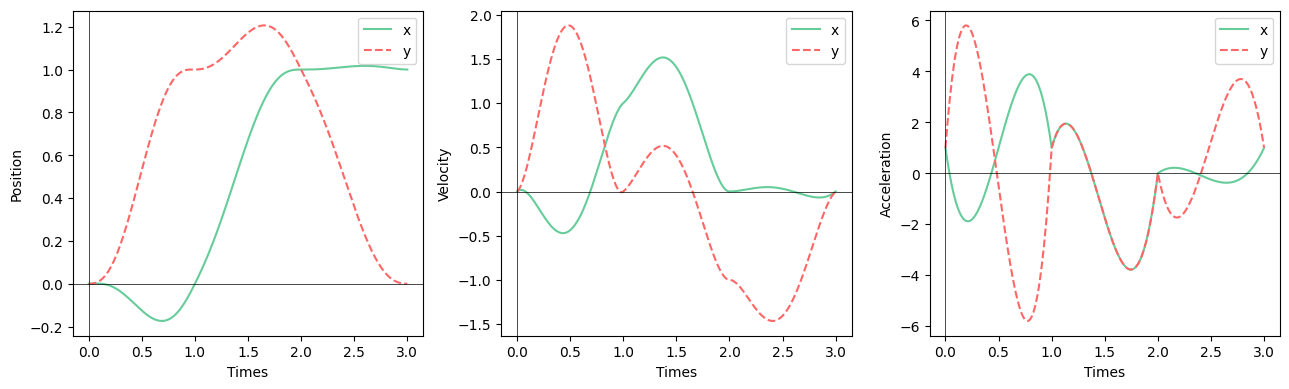

In [209]:
fig, axis = plt.subplots(1, 3, figsize=(13, 4))

y_labels = ('Position','Velocity', 'Acceleration')

x = InterLine(color='#6c9',linestyle='solid',name='x', time_cofs=c_x)
y = InterLine(color='#f66',linestyle='dashed',name='y', time_cofs=c_y)

lines = (x, y)

fnc_list = (poly, get_dpoly, get_ddpoly)

for fnc, ax, y_label in zip(fnc_list, axis, y_labels):
  for line in lines:
    line.plot(ax, t, fnc)

  ax.axhline(0, color='black', linewidth=0.5)
  ax.axvline(0, color='black', linewidth=0.5)
  ax.set_xlabel('Times')
  ax.set_ylabel(y_label)
  ax.legend()

plt.tight_layout()
plt.show()